In [93]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
from pvlive_api import PVLive
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

import json


from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.all import *
from sktime.forecasting.compose import *
from sktime.forecasting.model_selection import ForecastingGridSearchCV

import datetime

In [94]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# MODEL

In [95]:
germany_df = pd.read_csv("data/historicgeneration.csv")
germany_df = germany_df.iloc[:-1]
germany_df.head()

,ignore,date,period,CGST,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTNEM,INTELEC,INTIFA2,INTNSL
0,FUELHH,20210704,1.0000,8218.0000,0.0000,0.0000,4718.0000,3691.0000,2.0000,55.0000,1.0000,149.0000,1508.0000,0.0000,762.0000,0.0000,1590.0000,754.0000,0.0000,752.0000,0.0000
1,FUELHH,20210704,2.0000,7520.0000,0.0000,0.0000,4718.0000,3451.0000,20.0000,55.0000,0.0000,346.0000,1508.0000,0.0000,760.0000,0.0000,1569.0000,754.0000,0.0000,748.0000,0.0000
2,FUELHH,20210704,3.0000,7402.0000,0.0000,0.0000,4720.0000,3429.0000,0.0000,55.0000,0.0000,344.0000,1410.0000,0.0000,712.0000,0.0000,1567.0000,706.0000,0.0000,704.0000,0.0000
3,FUELHH,20210704,4.0000,7284.0000,0.0000,0.0000,4720.0000,3430.0000,0.0000,55.0000,0.0000,261.0000,1408.0000,0.0000,712.0000,0.0000,1611.0000,706.0000,0.0000,702.0000,0.0000
4,FUELHH,20210704,5.0000,6970.0000,0.0000,0.0000,4720.0000,3476.0000,0.0000,55.0000,0.0000,141.0000,1410.0000,0.0000,714.0000,0.0000,1546.0000,706.0000,0.0000,702.0000,0.0000


In [96]:
germany_df.shape

(1475, 21)

In [97]:
germany_df['Period'] = germany_df['period'] * 30
germany_df['Period'] = germany_df['Period'].apply(lambda x:datetime.timedelta(minutes=x))

In [98]:
germany_df['date'] = germany_df['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
germany_df['datetime'] = germany_df['date'] + germany_df['Period']

In [99]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-07-04 00:30:00


Timestamp('2021-08-03 17:30:00')

In [100]:
pvl = PVLive()
df = pvl.between(start=datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30), end=datetime.datetime.now(datetime.timezone.utc), dataframe=True)

In [101]:
df.rename(columns={'generation_mw' : 'SOLAR'}, inplace=True)
df.head()

,pes_id,datetime_gmt,SOLAR
0,0,2021-08-03 18:00:00+00:00,1420.0000
1,0,2021-08-03 17:30:00+00:00,2060.0000
2,0,2021-08-03 17:00:00+00:00,2600.0000
3,0,2021-08-03 16:30:00+00:00,3270.0000
4,0,2021-08-03 16:00:00+00:00,3850.0000


In [102]:
df.rename(columns={'datetime_gmt' : 'datetime'}, inplace=True)
df.head()

,pes_id,datetime,SOLAR
0,0,2021-08-03 18:00:00+00:00,1420.0000
1,0,2021-08-03 17:30:00+00:00,2060.0000
2,0,2021-08-03 17:00:00+00:00,2600.0000
3,0,2021-08-03 16:30:00+00:00,3270.0000
4,0,2021-08-03 16:00:00+00:00,3850.0000


In [103]:
day_light_saving = True

In [104]:
if day_light_saving == True:
    germany_df['datetime'] = germany_df['datetime'] - datetime.timedelta(hours=1)
germany_df['datetime'] = pd.to_datetime(germany_df['datetime'], utc = True)

In [105]:
dff = pd.merge(germany_df,df,on='datetime',how='inner')

In [106]:
#Drop unnecessary columns
#solar, biomass, wind, nuclear, PS, NPSHYD
dff['low_carbon'] = dff['SOLAR'] + dff['BIOMASS'] + dff['WIND'] + dff['NUCLEAR'] + dff['PS'] + dff['NPSHYD']
dff['high_carbon'] = dff['OIL'] + dff['CGST'] + dff['COAL'] + dff['OCGT'] + dff['OTHER'] + dff['INTFR'] + dff['INTIRL'] + dff['INTNED'] + dff['INTEW'] + dff['INTNEM'] + dff['INTELEC'] + dff['INTIFA2'] + dff['INTNSL']
df_main = dff[['low_carbon', 'high_carbon', 'datetime']]
df_main.head()

,low_carbon,high_carbon,datetime
0,12825.0000,16638.0000,2021-07-04 19:00:00+00:00
1,12063.0000,16779.0000,2021-07-04 19:30:00+00:00
2,11602.3000,16647.0000,2021-07-04 20:00:00+00:00
3,11697.2400,15830.0000,2021-07-04 20:30:00+00:00
4,11545.9360,15215.0000,2021-07-04 21:00:00+00:00


In [107]:
germany_df = df_main.copy()

In [108]:
germany_df = germany_df.set_index('datetime')

In [109]:
germany_df = germany_df.iloc[1:]
germany_df

,low_carbon,high_carbon
datetime,,
2021-07-04 19:30:00+00:00,12063.0000,16779.0000
2021-07-04 20:00:00+00:00,11602.3000,16647.0000
2021-07-04 20:30:00+00:00,11697.2400,15830.0000
2021-07-04 21:00:00+00:00,11545.9360,15215.0000
2021-07-04 21:30:00+00:00,11933.1500,14520.0000
...,...,...
2021-08-03 14:30:00+00:00,13304.0000,20188.0000
2021-08-03 15:00:00+00:00,12927.0000,20444.0000
2021-08-03 15:30:00+00:00,12651.0000,20933.0000


In [110]:
germany_df['ratio'] = germany_df['low_carbon'] / germany_df['high_carbon']

In [111]:
# Save cleaned dataset as CSV file
germany_df.to_csv('data/cleaned_energy_data.csv')

# Low carbon Modeling

<AxesSubplot:xlabel='datetime'>

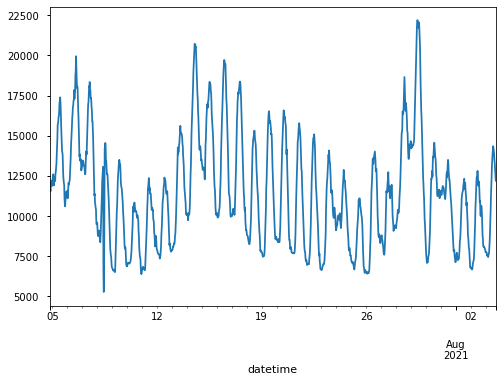

In [112]:
solar_ts = germany_df['low_carbon']
solar_ts.plot()

### Sktime

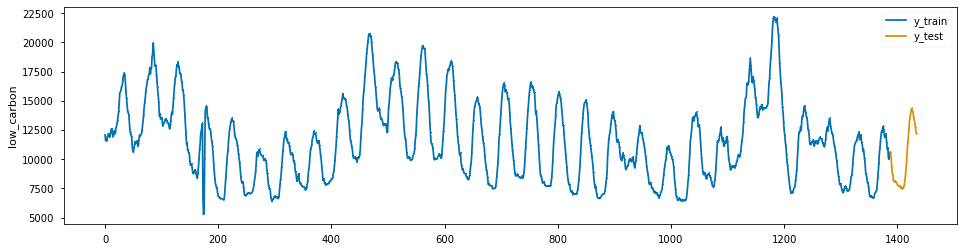

In [113]:
y = solar_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.08708129198515786

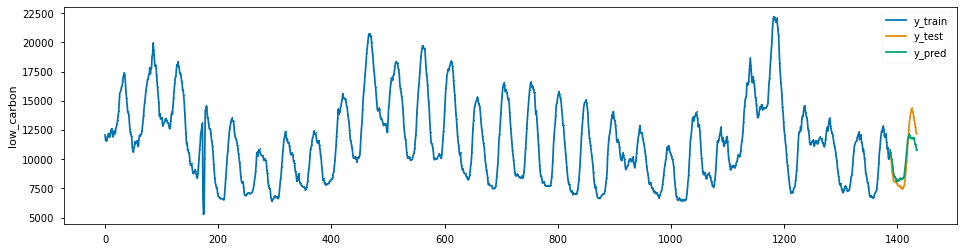

In [114]:
from xgboost import XGBRegressor
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

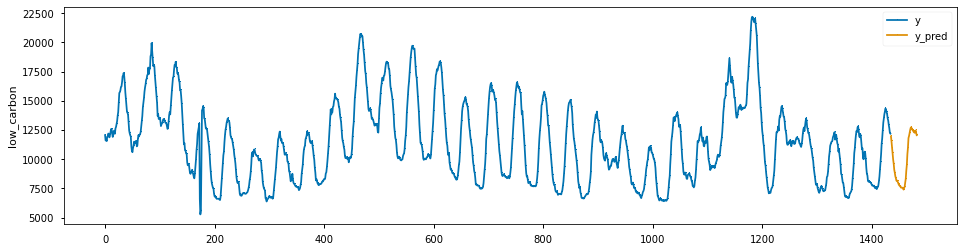

In [115]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_lowcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# High carbon Modeling

<AxesSubplot:xlabel='datetime'>

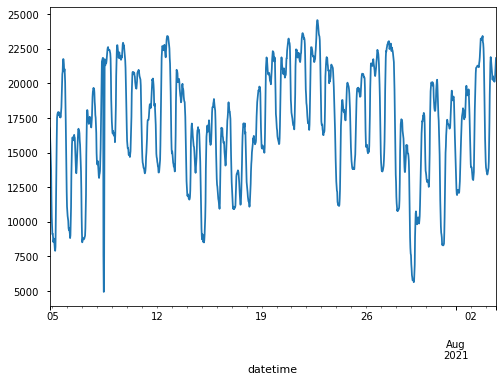

In [116]:
wind_ts = germany_df['high_carbon']
wind_ts.plot()

### Sktime

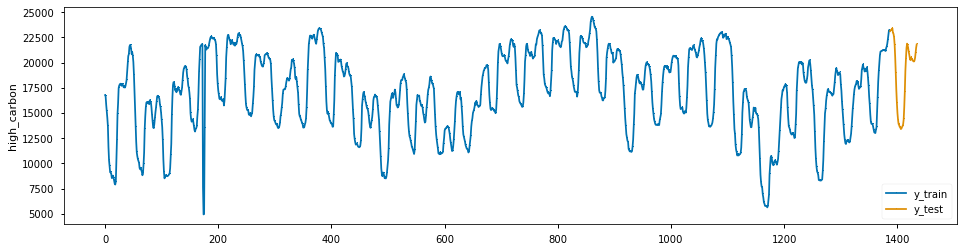

In [117]:
y = wind_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.09821595835202641

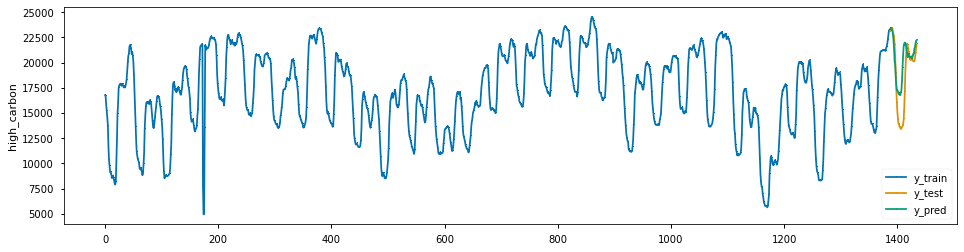

In [118]:
from xgboost import XGBRegressor

estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

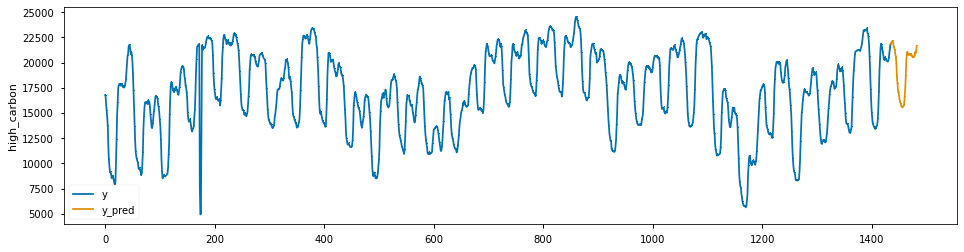

In [119]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_highcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# Ratio modeling

<AxesSubplot:xlabel='datetime'>

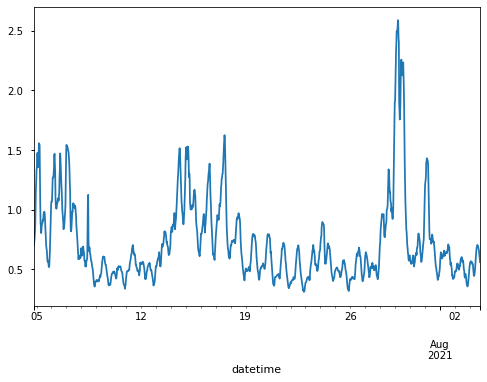

In [120]:
ratio = germany_df['ratio']
ratio.plot()

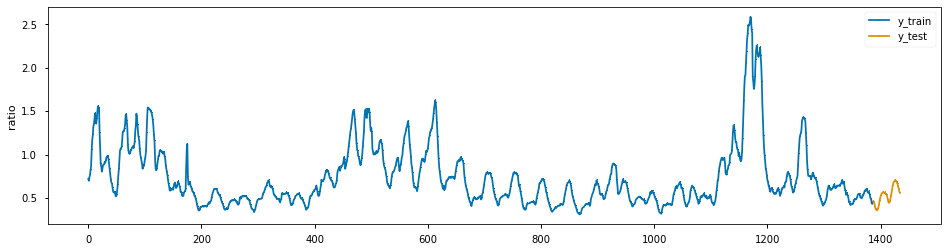

In [121]:
y = ratio.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='ratio'>)

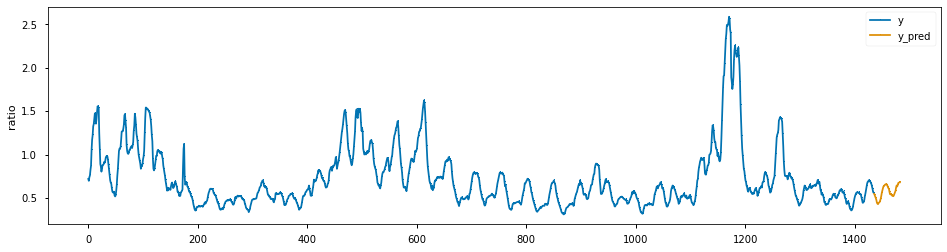

In [122]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_ratio = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

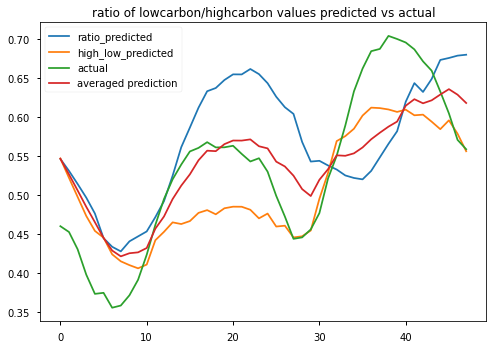

In [123]:
plt.plot(np.array(y_ratio), label = 'ratio_predicted')
plt.plot(np.array(y_lowcarbon/y_highcarbon), label = 'high_low_predicted')
plt.plot(np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True)), label = 'actual')
plt.plot((np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2, label = 'averaged prediction')
plt.legend()
plt.title('ratio of lowcarbon/highcarbon values predicted vs actual')
plt.savefig('data/results_comparison.png')

In [124]:
germany_df.iloc[:-48].index

DatetimeIndex(['2021-07-04 19:30:00+00:00', '2021-07-04 20:00:00+00:00',
               '2021-07-04 20:30:00+00:00', '2021-07-04 21:00:00+00:00',
               '2021-07-04 21:30:00+00:00', '2021-07-04 22:00:00+00:00',
               '2021-07-04 22:30:00+00:00', '2021-07-04 23:00:00+00:00',
               '2021-07-04 23:30:00+00:00', '2021-07-05 00:00:00+00:00',
               ...
               '2021-08-02 12:00:00+00:00', '2021-08-02 12:30:00+00:00',
               '2021-08-02 13:00:00+00:00', '2021-08-02 13:30:00+00:00',
               '2021-08-02 14:00:00+00:00', '2021-08-02 14:30:00+00:00',
               '2021-08-02 15:00:00+00:00', '2021-08-02 15:30:00+00:00',
               '2021-08-02 16:00:00+00:00', '2021-08-02 16:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=1387, freq=None)

In [125]:
import os
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
options = webdriver.ChromeOptions()


options = webdriver.ChromeOptions()
prefs = {'download.default_directory' : r'C:\Users\AH05350\Documents\self\documents\Umesh\API_fetch_smarthome\energy_dashboard-master\data'}
options.add_experimental_option('prefs', prefs)
options.add_argument("--headless")


driver = webdriver.Chrome(r"./data/chromedriver.exe", chrome_options=options)
driver.get('https://www.energy-stats.uk/wp-content/historic-data/csv_agile_A_Eastern_England.csv')

<ipython-input-125-31781616a7b3>:16: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(r"./data/chromedriver.exe", chrome_options=options)


In [126]:
df_price = pd.read_csv('data/csv_agile_A_Eastern_England.csv')

In [127]:
df_price.columns = ['datetime_utc', 'datetime_uk', 'zone', 'DNoS', 'price']

In [128]:
df_price['datetime_utc'] = pd.to_datetime(df_price['datetime_utc'], utc = True)

In [129]:
df_price.drop(columns=['datetime_uk', 'zone', 'DNoS'], inplace=True)

In [130]:
df_price = df_price.set_index('datetime_utc')

In [131]:
l = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(germany_df.index.max() + datetime.timedelta(minutes=30), germany_df.index.max() + datetime.timedelta(days =1),
                                      freq='30T')))

In [132]:
l['ratio']= np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True))
l['ratio_predicted'] = np.array(y_ratio)
l['low_high_ratio_predicted'] = np.array(y_lowcarbon/y_highcarbon)
l['averaged_prediction'] = (np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2

In [133]:
df_final = df_price.join(l, how='inner')
df_final.to_csv('data/prediction_data_withprice.csv')

In [134]:
user_input = 3 #input in terms of hours

In [135]:
xx = np.asarray(df_final['ratio_predicted']/df_final['price'])

In [136]:
N = user_input * 2
moving_aves = np.convolve(xx, np.ones(N)/N, mode='valid')

In [137]:
df_final.index[np.argmax(moving_aves)]

Timestamp('2021-08-04 02:00:00+0000', tz='UTC')

In [138]:
weather = pd.read_json('./data/weather.json').T

In [139]:
weather.columns = ['clouds', 'rain', 'datetime_uk','temperature', 'icon', 'wind']

In [140]:
weather.head()

,clouds,rain,datetime_uk,temperature,icon,wind
0,81,0.4200,2021-08-03 18:00:00,19.3800,10d,3.0400
1,46,0.1500,2021-08-03 21:00:00,17.1100,10n,2.3400
2,19,0,2021-08-04 00:00:00,14.4200,02n,1.8600
3,9,0,2021-08-04 03:00:00,13.3900,01n,1.4900
4,38,0,2021-08-04 06:00:00,14.1700,03d,0.9700


In [141]:
weather['datetime_uk'] = pd.to_datetime(weather['datetime_uk'], utc = True)
if day_light_saving == True:
    weather['datetime_uk'] = weather['datetime_uk'] - datetime.timedelta(hours=1)

In [142]:
weather.head()

,clouds,rain,datetime_uk,temperature,icon,wind
0,81,0.4200,2021-08-03 17:00:00+00:00,19.3800,10d,3.0400
1,46,0.1500,2021-08-03 20:00:00+00:00,17.1100,10n,2.3400
2,19,0,2021-08-03 23:00:00+00:00,14.4200,02n,1.8600
3,9,0,2021-08-04 02:00:00+00:00,13.3900,01n,1.4900
4,38,0,2021-08-04 05:00:00+00:00,14.1700,03d,0.9700


In [143]:
import httplib2
import pandas as pd
import numpy as np
import json
import configparser

config = configparser.ConfigParser()		
config.read("API_keys.ini")
apikey_openweather = config['APIKEY_ACCUWEATHER']
API = apikey_openweather['key']

In [144]:
http_obj = httplib2.Http()
resp, content = http_obj.request(
    uri='http://dataservice.accuweather.com/forecasts/v1/hourly/12hour/328328?apikey=' + API,
    method='GET',
    headers={'Content-Type':'application/json: charset=UTF-8'}
)

dict = json.loads(content)

In [145]:
df = pd.json_normalize(dict)
df.head()

,DateTime,EpochDateTime,WeatherIcon,IconPhrase,HasPrecipitation,IsDaylight,PrecipitationProbability,MobileLink,Link,Temperature.Value,Temperature.Unit,Temperature.UnitType
0,2021-08-03T20:00:00+01:00,1628017200,3,Partly sunny,False,True,7,http://www.accuweather.com/en/gb/london/ec4a-2...,http://www.accuweather.com/en/gb/london/ec4a-2...,64.0000,F,18
1,2021-08-03T21:00:00+01:00,1628020800,35,Partly cloudy,False,False,7,http://www.accuweather.com/en/gb/london/ec4a-2...,http://www.accuweather.com/en/gb/london/ec4a-2...,62.0000,F,18
2,2021-08-03T22:00:00+01:00,1628024400,35,Partly cloudy,False,False,7,http://www.accuweather.com/en/gb/london/ec4a-2...,http://www.accuweather.com/en/gb/london/ec4a-2...,61.0000,F,18
3,2021-08-03T23:00:00+01:00,1628028000,35,Partly cloudy,False,False,7,http://www.accuweather.com/en/gb/london/ec4a-2...,http://www.accuweather.com/en/gb/london/ec4a-2...,60.0000,F,18
4,2021-08-04T00:00:00+01:00,1628031600,35,Partly cloudy,False,False,7,http://www.accuweather.com/en/gb/london/ec4a-2...,http://www.accuweather.com/en/gb/london/ec4a-2...,59.0000,F,18


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DateTime                  12 non-null     object 
 1   EpochDateTime             12 non-null     int64  
 2   WeatherIcon               12 non-null     int64  
 3   IconPhrase                12 non-null     object 
 4   HasPrecipitation          12 non-null     bool   
 5   IsDaylight                12 non-null     bool   
 6   PrecipitationProbability  12 non-null     int64  
 7   MobileLink                12 non-null     object 
 8   Link                      12 non-null     object 
 9   Temperature.Value         12 non-null     float64
 10  Temperature.Unit          12 non-null     object 
 11  Temperature.UnitType      12 non-null     int64  
dtypes: bool(2), float64(1), int64(4), object(5)
memory usage: 1.1+ KB


In [147]:
df['DateTime'] = pd.to_datetime(df['DateTime'], utc = True)
if day_light_saving == True:
    df['DateTime'] = df['DateTime'] - datetime.timedelta(hours=1)

In [148]:
dt = df_final.index[np.argmax(moving_aves)]

In [149]:
df = df.set_index('DateTime')
df.index

DatetimeIndex(['2021-08-03 18:00:00+00:00', '2021-08-03 19:00:00+00:00',
               '2021-08-03 20:00:00+00:00', '2021-08-03 21:00:00+00:00',
               '2021-08-03 22:00:00+00:00', '2021-08-03 23:00:00+00:00',
               '2021-08-04 00:00:00+00:00', '2021-08-04 01:00:00+00:00',
               '2021-08-04 02:00:00+00:00', '2021-08-04 03:00:00+00:00',
               '2021-08-04 04:00:00+00:00', '2021-08-04 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DateTime', freq=None)

In [150]:
idx = df.index.get_loc(dt, method='nearest')
print(df.index[idx])

2021-08-04 02:00:00+00:00


In [151]:

import smtplib
def sendEmail(text):
    server = smtplib.SMTP_SSL("smtp.gmail.com",465)
    server.login("t6811930@gmail.com","Bodla@123")
    server.sendmail("t6811930@gmail.com","ashishbodla@gmail.com",text)
    server.quit()

In [152]:
dt

Timestamp('2021-08-04 02:00:00+0000', tz='UTC')

In [153]:
text = "This is program generated Email. The Ideal time to use for the next " + str(user_input) + "hours is \n" + str(dt) + " UTC \n The weather at the specified duration\
      is " + df['IconPhrase'].iloc[idx] +" and Precipitation probability is " + str(df['PrecipitationProbability'].iloc[idx] / 100)  +  ". \nHave a Great Day!" 
subject = "Project Finished"
message = 'Subject: {}\n\n{}'.format(subject, text)
sendEmail(message)

In [154]:
dt

Timestamp('2021-08-04 02:00:00+0000', tz='UTC')